In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from scripts.drawer import russia_plots
import geopandas as gpd
import pandas as pd
import numpy as np
import glob

### Russia geom

In [4]:
gauges_file = gpd.read_file('../geo_data/great_db/geometry/russia_ws.gpkg')
basemap_data = gpd.read_file('../geo_data/great_db/geometry/russia_forest_25people.geojson')

In [5]:
test_gauges = pd.read_csv('./data/basins_test.txt', names=['gauge_id'])
test_gauges['gauge_id'] = test_gauges['gauge_id'].astype(str)
train_gauges = pd.read_csv('./data/basins_train.txt', names=['gauge_id'])
train_gauges['gauge_id'] = train_gauges['gauge_id'].astype(str)
val_gauges = pd.read_csv('./data/basins_val.txt', names=['gauge_id'])
val_gauges['gauge_id'] = val_gauges['gauge_id'].astype(str)

for i, val in enumerate(gauges_file.loc[:, 'gauge_id']):
    
    if val in test_gauges['gauge_id'].values:
        gauges_file.loc[i, 'status'] = 'test'
    elif val in train_gauges['gauge_id'].values:
        gauges_file.loc[i, 'status'] = 'train'
    elif val in val_gauges['gauge_id'].values:
        gauges_file.loc[i, 'status'] = 'val'
    else:
        gauges_file.loc[i, 'status'] = np.NaN
gauges_file

,gauge_id,name_ru,name_en,new_area,ais_dif,geometry,status
0,9002,р.Енисей - г.Кызыл,r.Enisej - g.Kyzyl,115263.989,0.230,"POLYGON ((96.87792 53.72792, 96.87792 53.72708...",NaN
1,9022,р.Енисей - пос.Никитино,r.Enisej - pos.Nikitino,184499.118,1.373,"POLYGON ((96.87792 53.72708, 96.88042 53.72708...",NaN
2,9053,р.Енисей - пос.Базаиха,r.Enisej - pos.Bazaiha,302690.417,0.897,"POLYGON ((92.38292 56.11042, 92.38292 56.10958...",NaN
3,9112,р.Большой Енисей - с.Тоора-Хем,r.Bol'shoj Enisej - s.Toora-Hem,15448.834,0.969,"POLYGON ((97.07125 52.71625, 97.07125 52.71542...",train
4,9115,р.Большой Енисей - пос.Сейба,r.Bol'shoj Enisej - pos.Sejba,44934.891,0.751,"POLYGON ((96.87792 53.72708, 96.88042 53.72708...",train
...,...,...,...,...,...,...,...
2075,11056,р.Иртыш - г.Тобольск,r.Irtysh - g.Tobol'sk,1540451.386,2.697,"POLYGON ((65.28125 59.37208, 65.28125 59.37125...",NaN
2076,11061,р.Иртыш - г.Ханты-Мансийск,r.Irtysh - g.Hanty-Mansijsk,1694019.131,2.668,"POLYGON ((62.66375 61.80542, 62.66542 61.80542...",NaN
2077,11801,р.Обь - г.Салехард,r.Ob' - g.Salehard,3004250.818,1.839,"POLYGON ((66.69042 66.42875, 66.69042 66.42792...",NaN
2078,10031,р.Обь - с.Белогорье,r.Ob' - s.Belogor'e,2738297.601,1.795,"POLYGON ((74.80958 63.03958, 74.80958 63.03875...",NaN


<class 'geopandas.geodataframe.GeoDataFrame'>


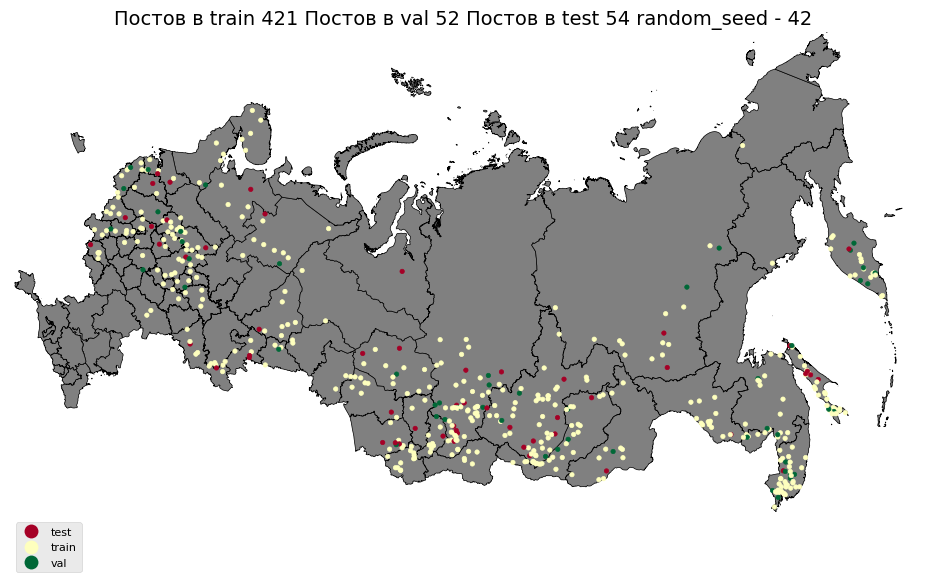

In [143]:
gauges_fig = russia_plots(gdf_to_plot=gauges_file.dropna(),
                          basemap_data=basemap_data,
                          distinction_col='status',
                          title_text=f"""Постов в train {len(train_gauges)}\
 Постов в val {len(val_gauges)}\
 Постов в test {len(test_gauges)}\
 random_seed - 42""",
                          just_points=True);


In [6]:
len(glob.glob('../geo_data/great_db/ais_data/q_h/*.csv'))

2814

In [9]:
q_obs = {'full': list(),
         'partial': list(),
         'empty': list()}
h_obs = {'full': list(),
         'partial': list(),
         'empty': list()}

def nan_fractor(df_col: pd.Series):
    nan_frac = df_col.isna().sum() / len(df_col)
    return nan_frac

nc_cond = [file.split('/')[-1][:-3] for file
           in glob.glob('../geo_data/great_db/nc_concat/*.nc')]

for file in glob.glob('../geo_data/great_db/ais_data/q_h/*.csv'):
    gauge_id = file.split('/')[-1][:-4]
    if gauge_id in nc_cond:
        test = pd.read_csv(file, index_col='date')
        lvls = test[['lvl_sm', 'lvl_mbs']]
        dschrg = test[['q_cms_s', 'q_mm_day']]
        
        fraction_of_nan_q = dschrg['q_cms_s'].isna().sum() / len(dschrg)
        
        if fraction_of_nan_q == 0.0:
            q_obs['full'].append(gauge_id)
        elif fraction_of_nan_q <= 0.25:
            q_obs['partial'].append(gauge_id)
        elif fraction_of_nan_q > 0.25:
            q_obs['empty'].append(gauge_id)
            
        fraction_of_nan_h = lvls['lvl_mbs'].isna().sum() / len(lvls)
        
        if fraction_of_nan_h == 0.0:
            h_obs['full'].append(gauge_id)
        elif fraction_of_nan_h <= 0.25:
            h_obs['partial'].append(gauge_id)
        elif fraction_of_nan_h > 0.25:
            h_obs['empty'].append(gauge_id)
    else:
        continue


In [10]:
[len(val) for val in h_obs.values()]

[1554, 467, 50]

In [11]:
[len(val) for val in q_obs.values()]

[1226, 506, 339]

### Plots for discharges

<class 'geopandas.geodataframe.GeoDataFrame'>


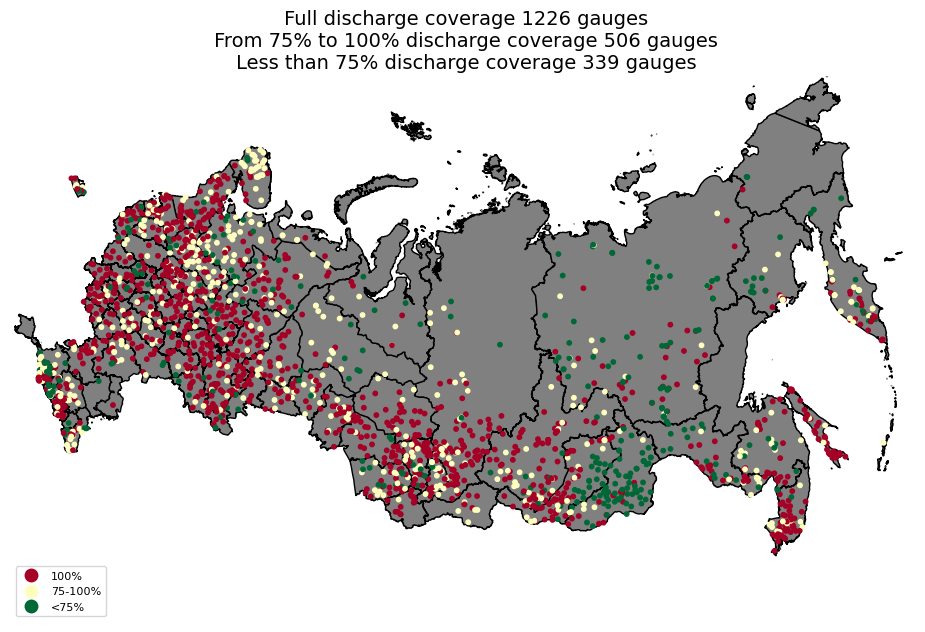

In [21]:
gauges_file = gpd.read_file('../geo_data/great_db/geometry/russia_gauges.gpkg')
for i, val in enumerate(gauges_file.loc[:, 'gauge_id']):
    
    if val in q_obs['full']:
        gauges_file.loc[i, 'status'] = '100%'
    elif val in q_obs['partial']:
        gauges_file.loc[i, 'status'] = '75-100%'
    elif val in q_obs['empty']:
        gauges_file.loc[i, 'status'] = '<75%'

gauges_fig = russia_plots(gdf_to_plot=gauges_file,
                          basemap_data=basemap_data,
                          distinction_col='status',
                          title_text=f"""\
 Full discharge coverage {len(q_obs['full'])} gauges\n\
 From 75% to 100% discharge coverage {len(q_obs['partial'])} gauges\n\
 Less than 75% discharge coverage {len(q_obs['empty'])} gauges""",
                          just_points=True);

### Levels

<class 'geopandas.geodataframe.GeoDataFrame'>


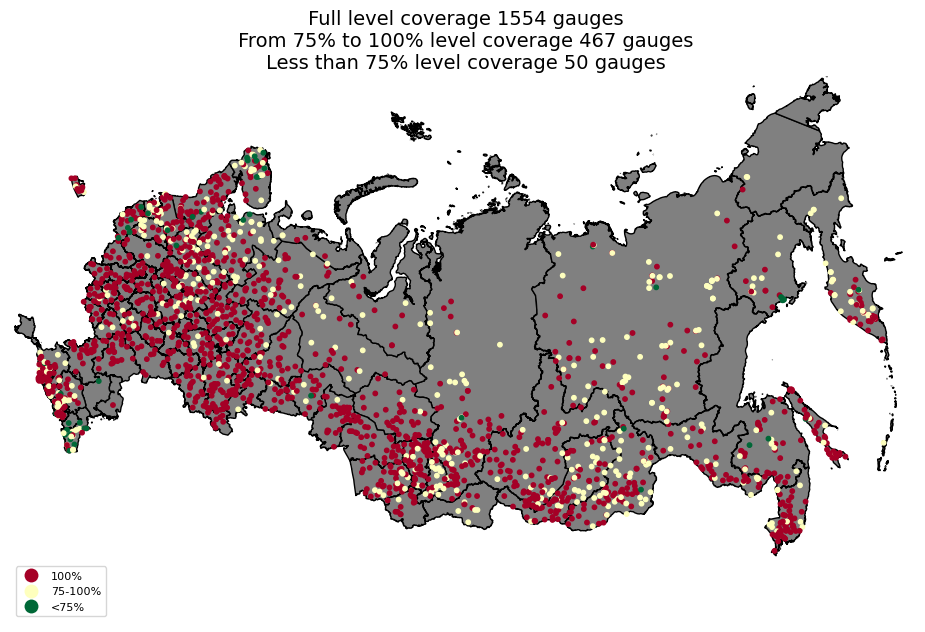

In [23]:
gauges_file = gpd.read_file('../geo_data/great_db/geometry/russia_gauges.gpkg')

for i, val in enumerate(gauges_file.loc[:, 'gauge_id']):
    
    if val in h_obs['full']:
        gauges_file.loc[i, 'status'] = '100%'
    elif val in h_obs['partial']:
        gauges_file.loc[i, 'status'] = '75-100%'
    elif val in h_obs['empty']:
        gauges_file.loc[i, 'status'] = '<75%'

gauges_fig = russia_plots(gdf_to_plot=gauges_file,
                          basemap_data=basemap_data,
                          distinction_col='status',
                          title_text=f"""\
 Full level coverage {len(h_obs['full'])} gauges\n\
 From 75% to 100% level coverage {len(h_obs['partial'])} gauges\n\
 Less than 75% level coverage {len(h_obs['empty'])} gauges""",
                          just_points=True);


In [11]:
def create_gdf_for_plot(df: pd.DataFrame,
                        geom_df: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """[summary]

    Args:
        df ([type]): [description]
        geom_df ([type]): [description]

    Returns:
        [type]: [description]
    """
    pd.options.mode.chained_assignment = None
    df['geometry'] = geom_df['centroids']
    df = gpd.GeoDataFrame(df)

    return df

### Meteo plots

In [6]:
from pathlib import Path
path_to_store = Path('./meteo_visualisations/')
path_to_store.mkdir(exist_ok=True, parents=True)
from typing import Tuple

def read_maurer(maurer_path: Path, basin: str) -> Tuple[pd.DataFrame, float]:
    """[summary]

    Args:
        basin (str): [description]

    Raises:
        RuntimeError: [description]

    Returns:
        Tuple[pd.DataFrame, float]: [description]
    """

    files = list(maurer_path.glob('**/*_forcing_leap.txt'))
    file_path = [f for f in files if f.name[:8] == basin]
    if len(file_path) == 0:
        raise RuntimeError(f'No file for Basin {basin} at {file_path}')
    else:
        file_path = file_path[0]

    df = pd.read_csv(file_path, sep='\s+', header=3)
    dates = (df.Year.map(str) + "/" + df.Mnth.map(str) + "/" + df.Day.map(str))
    df['date'] = pd.to_datetime(dates, format="%Y-%m-%d")
    df = df.set_index('date', drop=True)

    # load area from header
    with open(file_path, 'r') as fp:
        content = fp.readlines()
        area = round(float(content[2]), 2)
        area /= 10**6

    return df, area


In [7]:
gauges = list(area_data.index)

In [8]:
differ_files = dict()

for gauge in tqdm(gauges):
    # read meteo file
    area = area_data.loc[gauge, 'ws_area']
    meteo_maurer, _ = read_maurer(maurer_path=Path(
        './data/CAMELS/basin_mean_forcing/maurer_extended'
    ),
        basin=gauge)
    meteo_era = pd.read_csv(f'./data/CAMELS/forcings/{gauge}.csv')
    meteo_era['date'] = pd.to_datetime(meteo_era['date'])
    meteo_era = meteo_era.set_index('date', drop=True)

    res_file = meteo_era.join(meteo_maurer)
    res_file = res_file['01/01/1980':'12/31/2008']
    res_file = res_file.rename(columns={'prcp(mm/day)': 'prcp',
                                        'srad(W/m2)': 'srad',
                                        'swe(mm)': 'swe',
                                        'tmax(C)': 'tmax',
                                        'tmin(C)': 'tmin',
                                        'vp(Pa)': 'vp'})

    differ_files[gauge] = res_file[['temp_max', 'tmax', 'temp_min',
                                    'tmin', 'precip', 'prcp']]


def get_mae_prcp(gauge):
    precip, prcp = differ_files[gauge][['precip', 'prcp']].groupby(
        pd.Grouper(freq='1Y')).sum().mean().values

    res = prcp - precip
    area = area_data.loc[gauge, 'ws_area']

    return (precip, prcp, area)


fin_res = pd.DataFrame()
for gauge, val in differ_files.items():

    era, maurer, area = get_mae_prcp(gauge)
    fin_res.loc[gauge, 'area'] = area
    fin_res.loc[gauge, 'prcp_Era'] = era
    fin_res.loc[gauge, 'prcp_Maurer'] = maurer

fin_res['area_gradation'] = pd.cut(fin_res['area'],
                                   bins=[0, 250, 500, 1000, 2000, np.inf],
                                   right=False,
                                   include_lowest=False)
# group_fin = fin_res.groupby('area_gradation').mean()
era_df = pd.DataFrame()
era_df = fin_res[['area', 'prcp_Era']]
era_df = era_df.rename(columns={'prcp_Era': 'prcp'})
era_df.loc[:, 'tag'] = 'ERA5'

maurer_df = pd.DataFrame()
maurer_df = fin_res[['area', 'prcp_Maurer']]
maurer_df.loc[:, 'tag'] = 'Maurer'
maurer_df = maurer_df.rename(columns={'prcp_Maurer': 'prcp'})

maurer_vs_era = pd.concat([era_df, maurer_df]).reset_index(drop=True)


A Jupyter Widget

/tmp/ipykernel_1198/88103196.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maurer_df.loc[:, 'tag'] = 'Maurer'


In [ ]:
ws = gpd.read_file('../geo_data/great_db/geometry/russia_ws.gpkg')

def lim_definer(area: float):

    lim_1, lim_2, lim_3 = 100, 2000, 50000

    if area < lim_1:
        return '< 100 sq. km'
    elif (area >= lim_1) & (area <= lim_2):
        return '100 sq. km - 2 000 sq.km'
    elif (area >= lim_2) & (area <= lim_3):
        return '2 000 sq. km - 50 000 sq.km'
    else:
        return '> 50 000 sq.km'


ws['size'] = ws.loc[:, 'new_area'].apply(lambda x: lim_definer(x))
ws['size'] = pd.Categorical(ws['size'], ['< 100 sq. km',
                                         '100 sq. km - 2 000 sq.km',
                                         '2 000 sq. km - 50 000 sq.km',
                                         '> 50 000 sq.km'])


plt.figure(figsize=(15, 8))

area_hist = sns.histplot(data=ws,
                         x='size')
#  set the ticks first
area_hist.set_yticks(np.arange(0, 1100, 100));
# set the labels
area_hist.set_yticklabels(np.arange(0, 1100, 100));
area_hist.set_xlabel('Area range')
area_hist.set_ylabel('Number of objects')

area_hist.set_title(f"""Distribution of watersheds areas
for every created geometry""", fontsize=16);


In [9]:
fin_res


,area,prcp_Era,prcp_Maurer,area_gradation
01013500,2302.903431,1131.943053,986.478621,"[2000.0, inf)"
01022500,620.423845,1146.762302,1207.854828,"[500.0, 1000.0)"
01030500,3675.502151,1128.475597,1085.230345,"[2000.0, inf)"
01031500,766.509220,1176.784675,1161.034483,"[500.0, 1000.0)"
01047000,904.969099,1178.680671,1152.266207,"[500.0, 1000.0)"
...,...,...,...,...
14309500,226.431942,1329.677149,1843.521724,"[0.0, 250.0)"
14316700,588.244890,1582.616854,1603.937931,"[500.0, 1000.0)"
14325000,445.160763,1489.699641,2585.008276,"[250.0, 500.0)"
14362250,43.907511,1022.074773,945.884828,"[0.0, 250.0)"


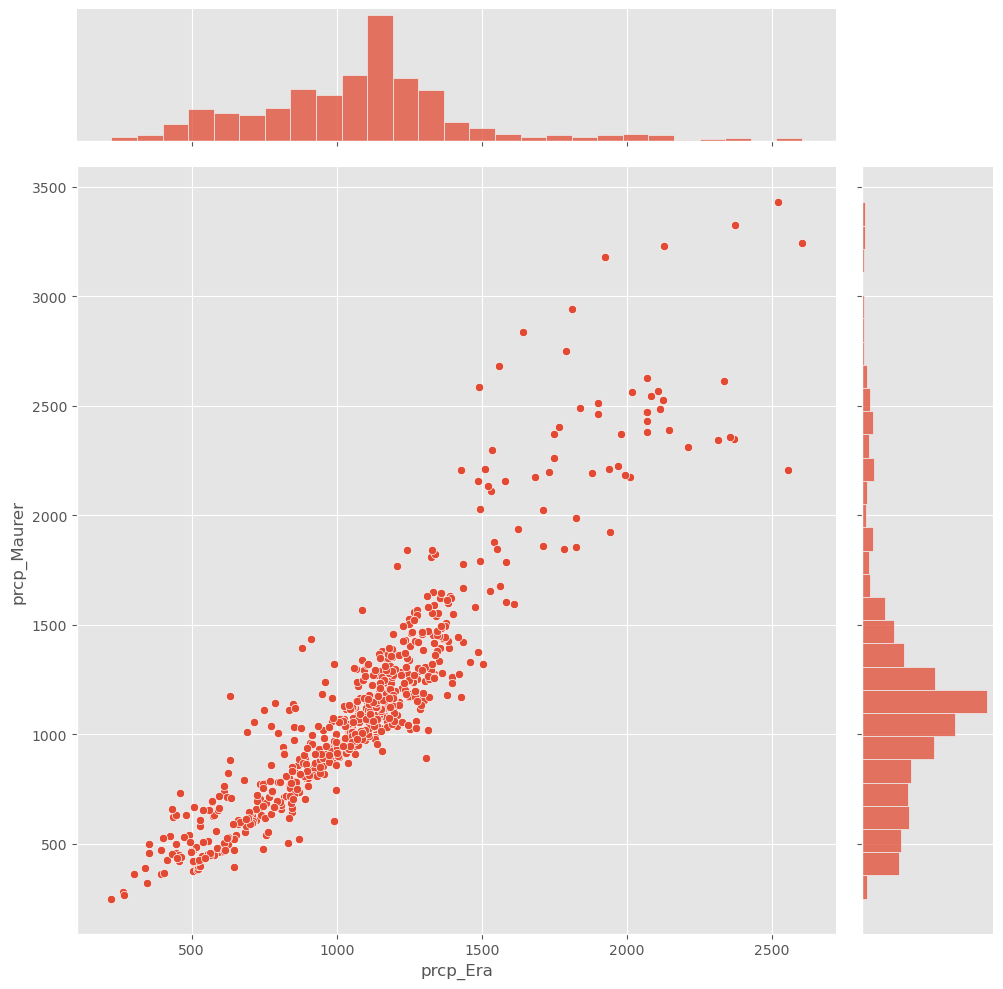

In [8]:
import seaborn as sns
sns.jointplot(data=fin_res, x="prcp_Era", y="prcp_Maurer", height=10);


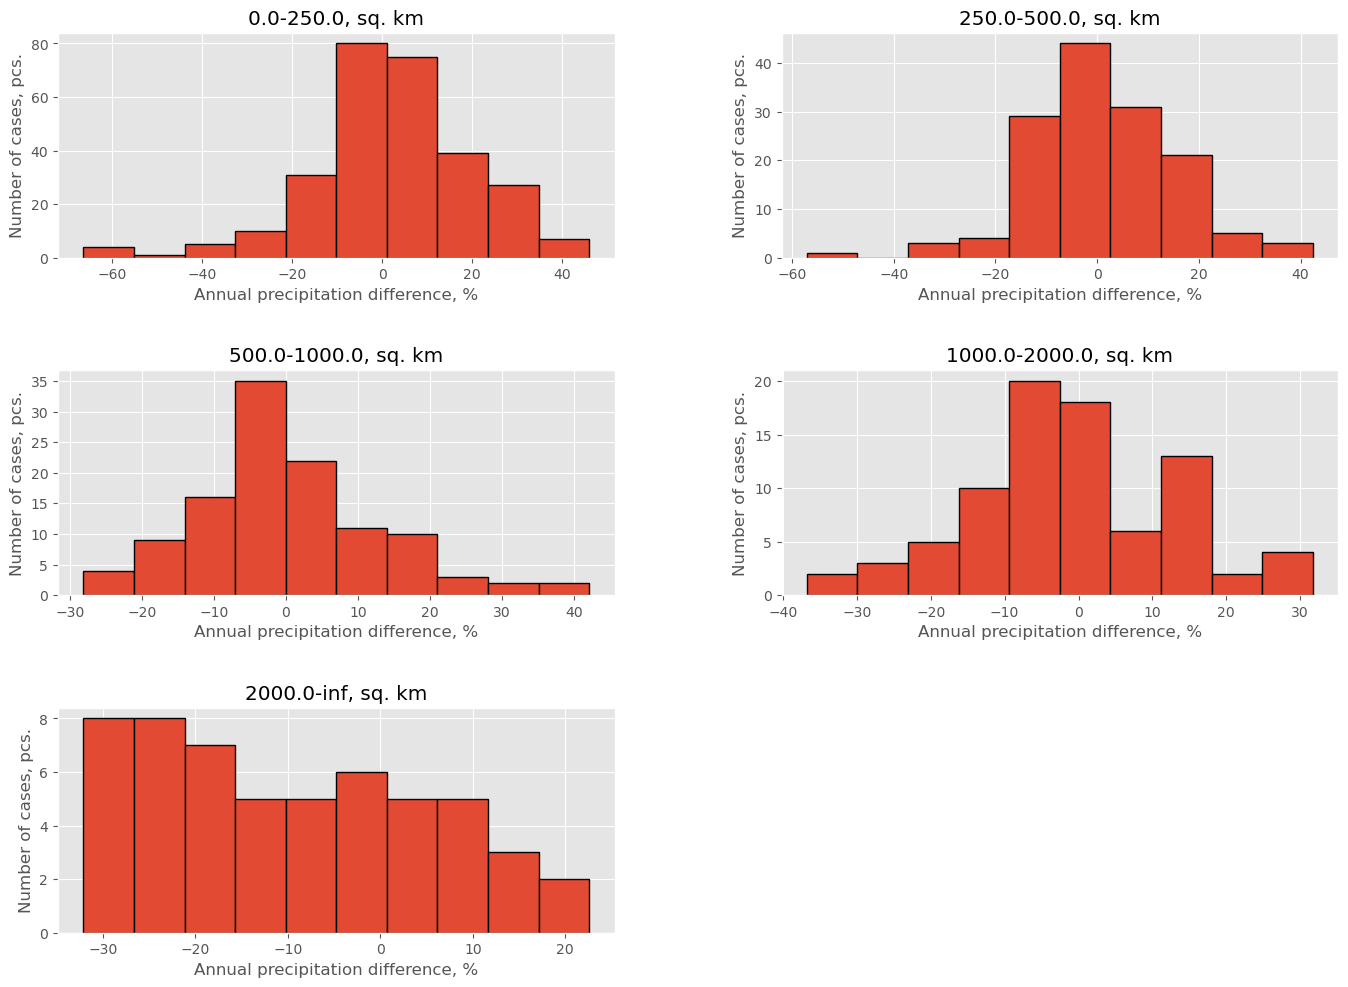

In [11]:
my_hist = fin_res.hist(column='prcp_diff',
                       by='area_gradation',
                       figsize=(16, 12),
                       edgecolor='black', linewidth=1)

xlbl = [str(col)[1:-1].replace(', ', '-')
        for col in np.unique(fin_res['area_gradation'])]
xlbl = [f'{lbl}, sq. km' for lbl in xlbl]

for i, ax in enumerate(my_hist.flatten()[:-1]):
    ax.set_title(xlbl[i])
    ax.set_xlabel("Annual precipitation difference, %")
    ax.set_ylabel('Number of cases, pcs.')
    ax.tick_params(axis='x', labelrotation=0);


In [11]:
from sklearn.metrics import r2_score


def get_r2(precip_df, frequency: str):
    precip_df = precip_df.groupby(pd.Grouper(freq=frequency)).sum()
    return r2_score(y_true=precip_df['prcp'],
                    y_pred=precip_df['precip'])


def value_hist(column_to_plot: str,
               frequency: str,
               xlabel: str):

    fin_res[column_to_plot] = [get_r2(data,
                                  frequency=frequency)
                           for data in differ_files.values()]

    my_hist = fin_res.hist(column=column_to_plot,
                           by='area_gradation',
                           figsize=(16, 12),
                           edgecolor='black', linewidth=1)

    xlbl = [str(col)[1:-1].replace(', ', '-')
            for col in np.unique(fin_res['area_gradation'])]
    xlbl = [f'{lbl}, кв. км' for lbl in xlbl]

    for i, ax in enumerate(my_hist.flatten()[:-1]):
        ax.set_title(xlbl[i])
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Число объектов, шт.')
        ax.tick_params(axis='x', labelrotation=0)


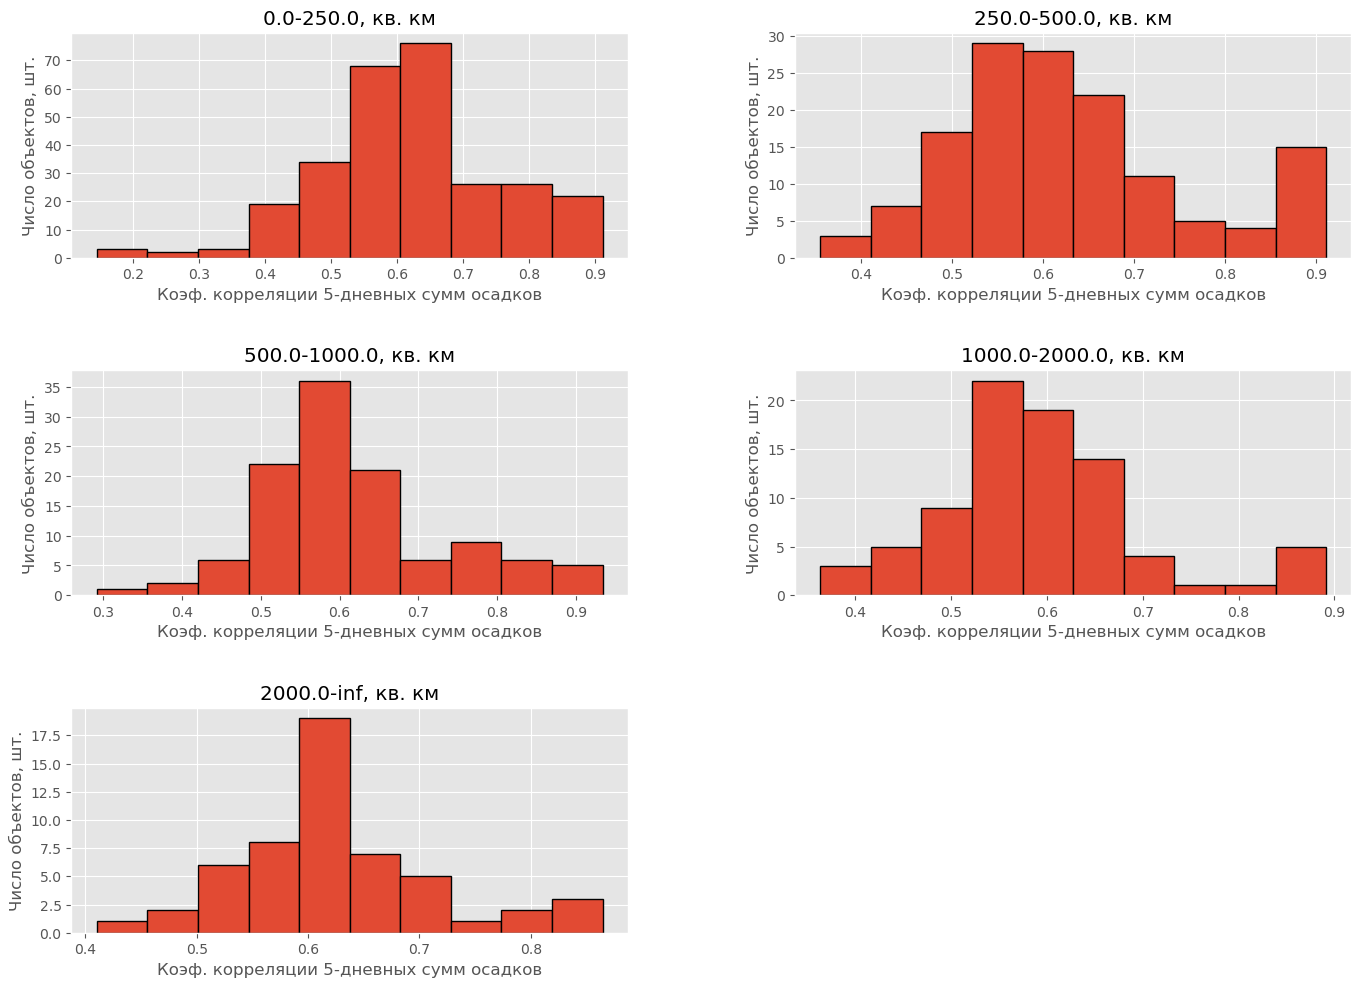

In [12]:
value_hist(column_to_plot='r2_5d',
           frequency='5d',
           xlabel="Коэф. корреляции 5-дневных сумм осадков")

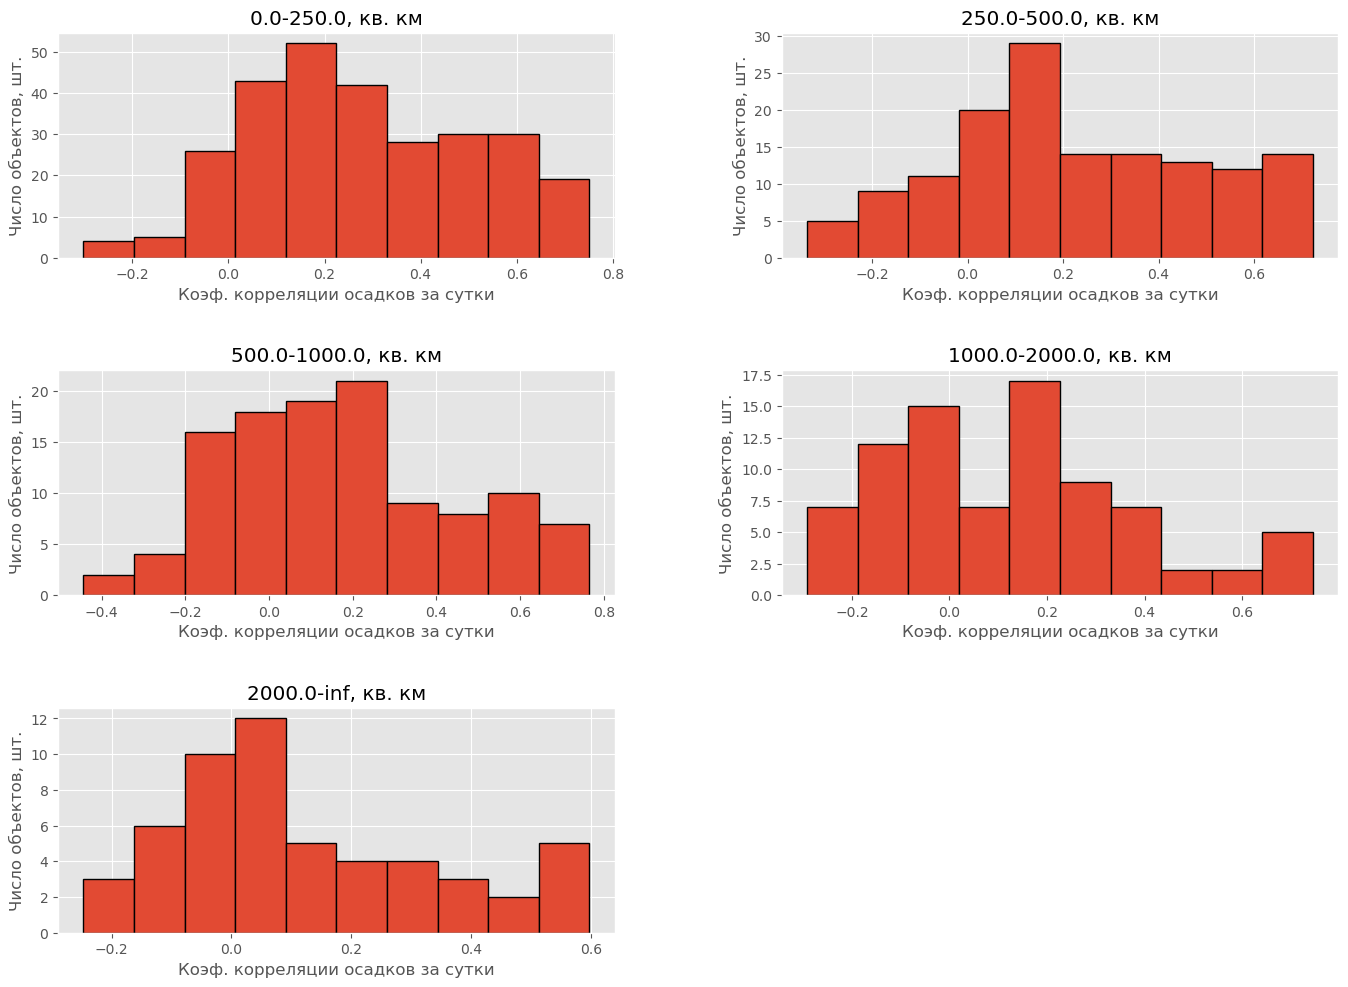

In [13]:
value_hist(column_to_plot='r2_daily',
           frequency='1d',
           xlabel="Коэф. корреляции осадков за сутки")